In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import keras

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # Disable warnings
tf.random.set_seed(42)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


I0000 00:00:1745522608.598703    2982 gpu_device.cc:2019] Created device /device:GPU:0 with 13499 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [3]:
train_ds, train_info = tfds.load('speech_commands', split='train', as_supervised=True, with_info=True)
val_ds, val_info = tfds.load('speech_commands', split='validation', as_supervised=True, with_info=True)
test_ds, test_info = tfds.load('speech_commands', split='test', as_supervised=True, with_info=True)

I0000 00:00:1745522626.335512    2982 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13499 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [16]:
for example in train_ds.take(1):
    print(example)


(<tf.Tensor: shape=(16000,), dtype=int16, numpy=array([-15, -18, -12, ...,  16,  21,  25], dtype=int16)>, <tf.Tensor: shape=(), dtype=int64, numpy=4>)


In [17]:
class_names = train_info.features['label'].names
print("Original class names:", class_names)

Original class names: ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', '_silence_', '_unknown_']


In [19]:
labels_train = [example[1] for example in train_ds]
labels_val = [example[1] for example in val_ds]
labels_test = [example[1] for example in test_ds]

print(f"train size: {len(labels_train)}\nval size: {len(labels_val)}\ntest size: {len(labels_test)}")

train size: 85511
val size: 10102
test size: 4890


['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', '_silence_', '_unknown_']


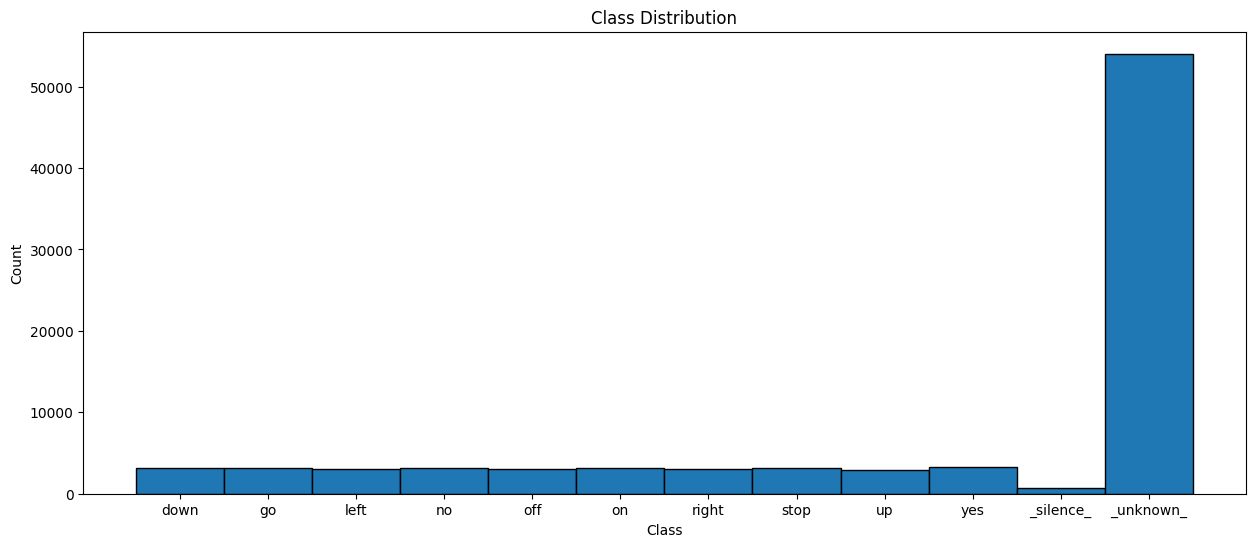

In [ ]:
print(class_names)
n_classes = len(class_names)
bin_edges = np.arange(-0.5, n_classes)

plt.figure(figsize=(15, 6))
plt.hist(labels_train, bins=bin_edges, edgecolor='black')
plt.xticks(ticks=range(len(class_names)), labels=class_names, ha='center')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [21]:
new_label_indexes = [0, 2, 6, 8, 10, 11]
labels_to_keep = tf.constant(new_label_indexes, dtype=tf.int64)
new_class_names = ['down', 'left', 'right', 'up', '_silence_', '_unknown_']
n_classes = len(new_class_names)

filtered_train_ds = train_ds.filter(
    lambda audio, label: tf.reduce_any(tf.math.equal(labels_to_keep, label))
)

In [22]:
label_mapping = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(new_label_indexes, dtype=tf.int64),
        values=tf.constant(list(range(len(new_label_indexes))), dtype=tf.int64)
    ),
    default_value=-1
)

def remap_labels(audio, label):
    new_label = label_mapping.lookup(label)
    return audio, new_label

remapped_train_ds = filtered_train_ds.map(remap_labels)

In [23]:
new_labels = []
for _, label in remapped_train_ds:
    new_labels.append(label.numpy())

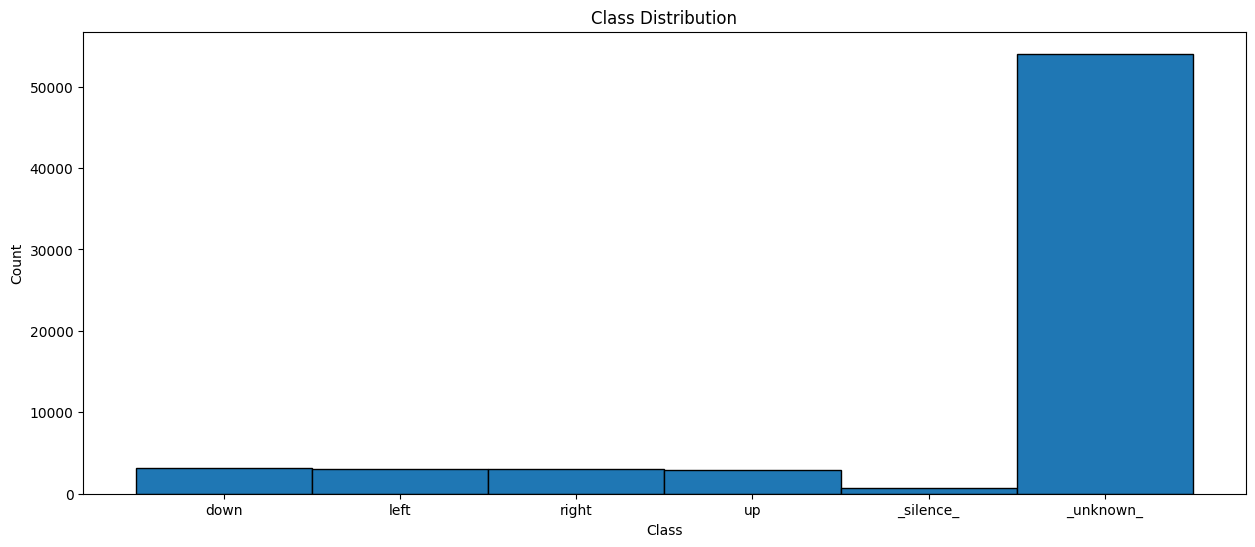

In [24]:
bin_edges = np.arange(-0.5, n_classes)
plt.figure(figsize=(15, 6))
plt.hist(new_labels, bins=bin_edges, edgecolor='black')
plt.xticks(ticks=range(n_classes), labels=new_class_names, ha='center')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [25]:
filtered_val_ds = val_ds.filter(
    lambda audio, label: tf.reduce_any(tf.math.equal(labels_to_keep, label))
)

filtered_test_ds = test_ds.filter(
    lambda audio, label: tf.reduce_any(tf.math.equal(labels_to_keep, label))
)

remapped_val_ds = filtered_val_ds.map(remap_labels)
remapped_test_ds = filtered_test_ds.map(remap_labels)

In [26]:
import IPython.display as ipd

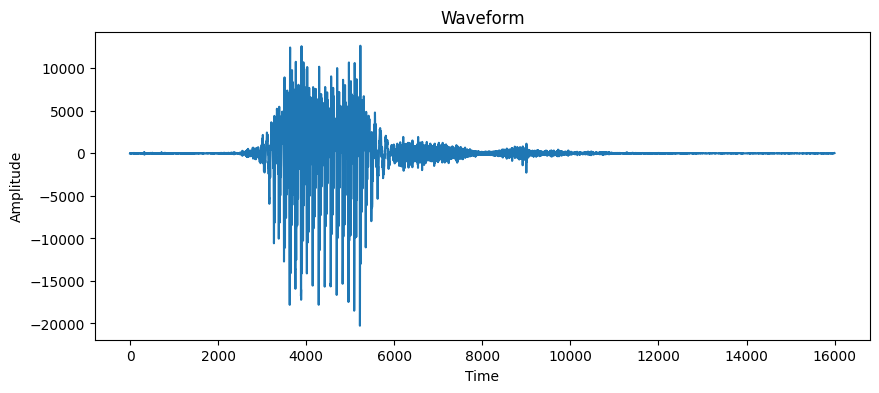

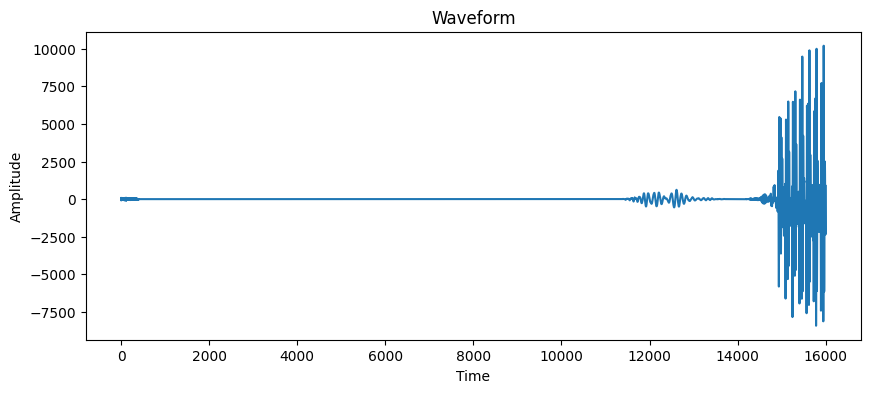

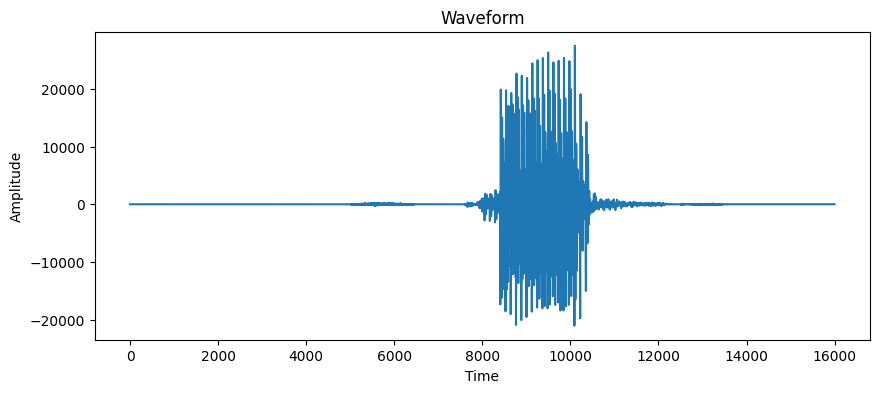

In [31]:
for example in train_ds.take(3):
  audio = example[0].numpy()
  sample_rate = train_info.features['audio'].sample_rate

  ipd.display(ipd.Audio(audio, rate=sample_rate))

  plt.figure(figsize=(10, 4))
  plt.plot(audio)
  plt.title("Waveform")
  plt.xlabel("Time")
  plt.ylabel("Amplitude")
  plt.show()

In [32]:
def create_model(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.Input(shape=input_shape),

        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2, 2)),
        
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2, 2)),
        
        keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [ ]:
def preprocess_dataset(ds, target_class_ids,
                       target_len=16000, sr=16000,
                       frame_length=256, frame_step=128,
                       n_mels=80):

    target_class_ids = tf.constant(target_class_ids)

    def _pre(audio, label):
        label = tf.cast(label, tf.int32)
        audio = tf.cast(audio, tf.float32)
        peak = tf.reduce_max(tf.abs(audio)) + 1e-9
        audio /= peak

        audio = audio[:target_len]
        pad_len = tf.maximum(0, target_len - tf.shape(audio)[0])
        audio = tf.pad(audio, [[0, pad_len]])

        stft = tf.signal.stft(audio, frame_length, frame_step,
                              pad_end=False)
        spec_mag = tf.abs(stft)

        W = tf.signal.linear_to_mel_weight_matrix(
            n_mels, spec_mag.shape[-1], sr, 0.0, sr/2)
        mel = tf.tensordot(spec_mag, W, axes=[[1], [0]])
        mel.set_shape([None, n_mels])

        log_mel = tf.math.log(mel + 1e-6)
        log_mel = tf.expand_dims(log_mel, -1) 

        loc = tf.where(tf.equal(label, target_class_ids))
        label_idx = tf.cond(tf.shape(loc)[0] > 0,
                            lambda: tf.cast(loc[0,0], tf.int32),
                            lambda: tf.constant(-1, dtype=tf.int32))
        one_hot = tf.one_hot(label_idx, len(target_class_ids))

        return log_mel, one_hot

    return (ds.map(_pre, num_parallel_calls=tf.data.AUTOTUNE))

In [34]:
def inspect_dataset(dataset):
    for spectrogram, label in dataset.take(1):
        print(f"Spectrogram shape: {spectrogram.shape}")
        print(f"Label shape: {label.shape}")
    return spectrogram.shape[1:]


In [54]:
target_class_ids = [new_class_names.index(cls) for cls in new_class_names]
preprocessed_train_ds = preprocess_dataset(remapped_train_ds, target_class_ids).batch(32).prefetch(tf.data.AUTOTUNE)
preprocessed_val_ds = preprocess_dataset(remapped_val_ds, target_class_ids).batch(32)
preprocessed_test_ds = preprocess_dataset(remapped_test_ds, target_class_ids).batch(32)

input_shape = inspect_dataset(preprocessed_train_ds)
print(f"Using input shape: {input_shape}")

model = create_model(input_shape, len(new_class_names))
model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.F1Score(average='macro')]
)

callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint('best_model_cnn.keras', save_best_only=True)
]

history = model.fit(
    preprocessed_train_ds,
    validation_data=preprocessed_val_ds,
    epochs=30,
    callbacks=callbacks
)

Spectrogram shape: (32, 124, 80, 1)
Label shape: (32, 6)
Using input shape: (124, 80, 1)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 124, 80, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 124, 80, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 62, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 62, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 62, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 31, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 31, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 31, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 15, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,134 (500.52 KB)

 Trainable params: 127,686 (498.77 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
   2084/Unknown 17s 7ms/step - f1_score: 0.4967 - loss: 0.5319

/mnt/c/Users/andre/projects/dat255/dat255-project/venv/tf-gpu-wsl/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - f1_score: 0.4974 - loss: 0.5313 - val_f1_score: 0.8731 - val_loss: 0.1703
Epoch 2/30
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - f1_score: 0.8789 - loss: 0.1574 - val_f1_score: 0.9187 - val_loss: 0.1154
Epoch 3/30
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - f1_score: 0.9178 - loss: 0.1156 - val_f1_score: 0.8351 - val_loss: 0.2566
Epoch 4/30
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - f1_score: 0.9335 - loss: 0.0967 - val_f1_score: 0.9203 - val_loss: 0.1116
Epoch 5/30
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - f1_score: 0.9414 - loss: 0.0860 - val_f1_score: 0.9138 - val_loss: 0.1146
Epoch 6/30
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - f1_score: 0.9482 - loss: 0.0772 - val_f1_score: 0.9093 - val_loss: 0.1231
Epoch 7/30
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - f1_score: 0.9529 - loss: 0.0705 - val_f1_score: 0.8938 - val_loss: 0.1665
Epoch 8/30
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - f1_score: 0.9544 - loss: 0.0670 - val

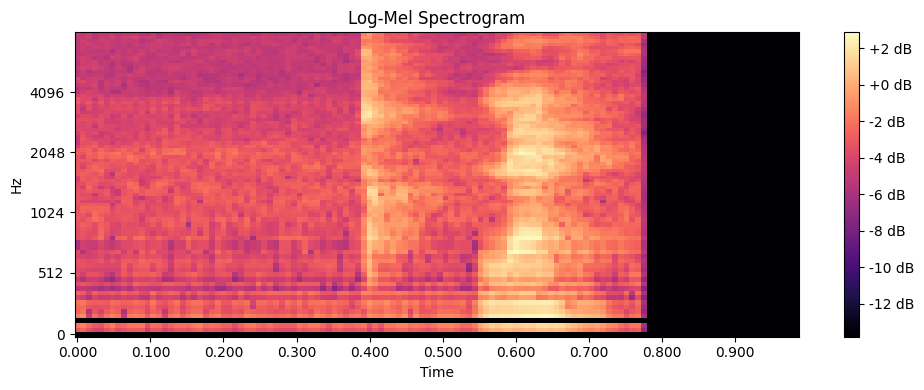

In [55]:
import librosa.display

def plot_spectrogram(spec, title="Log‑Mel Spectrogram"):
    spec = batch_spec[0].numpy().squeeze().T
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spec,
                            sr=16000,
                            hop_length=128,
                            x_axis='time',
                            y_axis='mel',
                            cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log‑Mel Spectrogram')
    plt.tight_layout()
    plt.show()

for batch_spec, batch_label in preprocessed_train_ds.take(1):
    plot_spectrogram(batch_spec[0])
    break

In [56]:
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LogNorm
import seaborn as sns


def plot_history(history):
    _, axs = plt.subplots(2, 1, figsize=(10, 10))

    axs[0].plot(history.history['f1_score'], label='train')
    axs[0].plot(history.history['val_f1_score'], label='validation')
    axs[0].set_title('Model F1 Score')
    axs[0].set_ylabel('F1 Score')
    axs[0].legend()

    axs[1].plot(history.history['loss'], label='train')
    axs[1].plot(history.history['val_loss'], label='validation')
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, dataset, class_names):
    y_pred = []
    y_true = []

    for x, y in dataset:
        predictions = model.predict(x, verbose=0)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(np.argmax(y, axis=1))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, norm=LogNorm())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

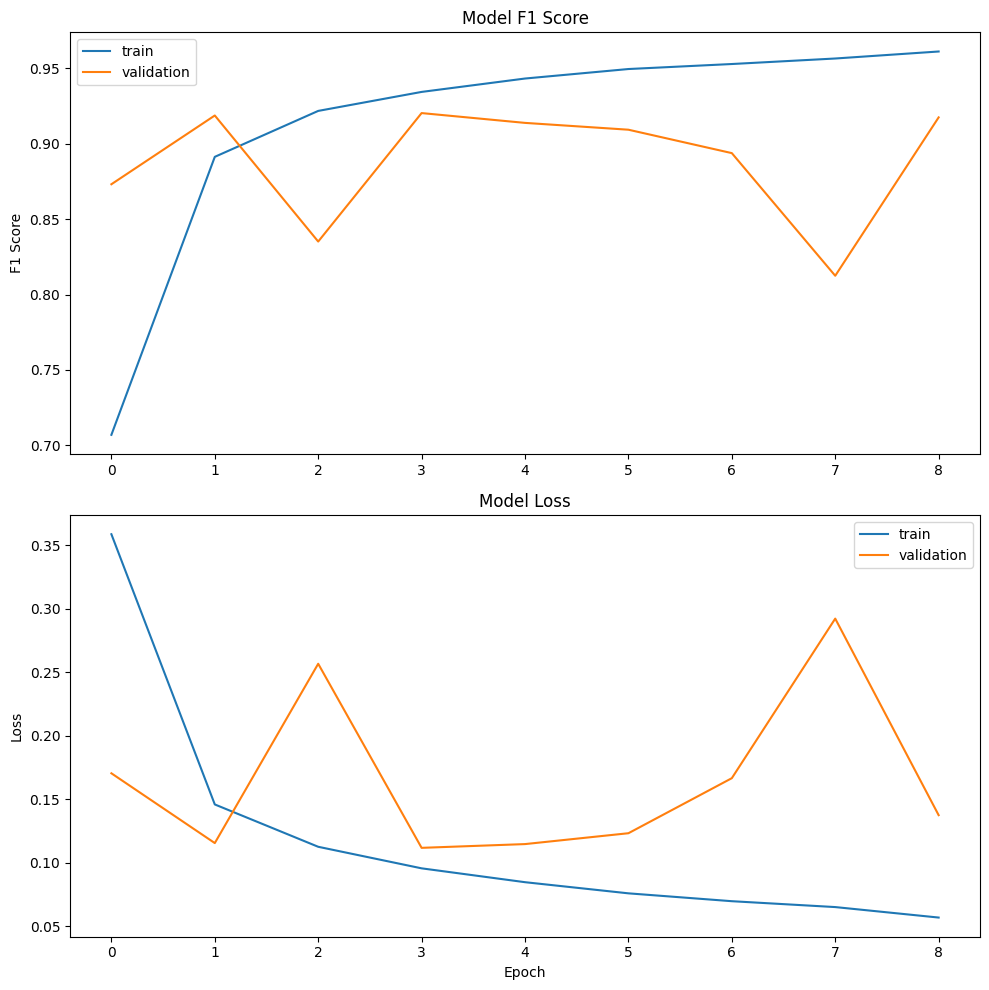

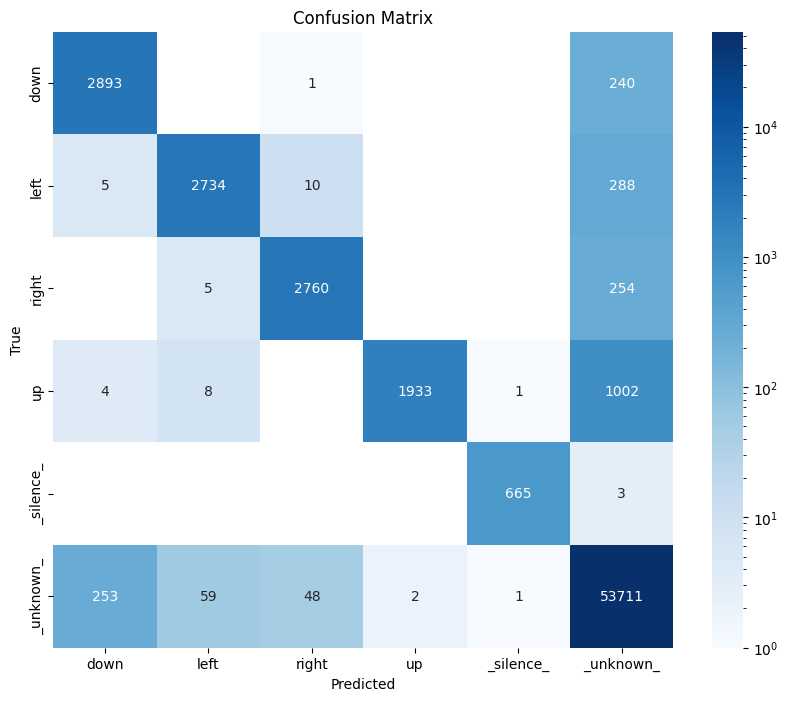

In [57]:
plot_history(history)
plot_confusion_matrix(model, preprocessed_train_ds, new_class_names)


In [58]:
def evaluate_model(model, preprocessed_test_ds):
    _, accuracy = model.evaluate(preprocessed_test_ds, verbose=0)
    print(f"Test accuracy: {accuracy:.4f}")

    all_preds = []
    all_labels = []
    for x, y in preprocessed_test_ds:
        preds = model.predict(x, verbose=0)
        all_preds.append(preds)
        all_labels.append(y)

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    from sklearn.metrics import classification_report
    pred_classes = np.argmax(all_preds, axis=1)
    true_classes = np.argmax(all_labels, axis=1)

    report = classification_report(true_classes, pred_classes, target_names=new_class_names)
    print(report)

In [59]:
evaluate_model(model, preprocessed_test_ds)

/mnt/c/Users/andre/projects/dat255/dat255-project/venv/tf-gpu-wsl/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Test accuracy: 0.8766
              precision    recall  f1-score   support

        down       0.98      0.89      0.93       406
        left       0.99      0.89      0.93       412
       right       0.99      0.87      0.93       396
          up       1.00      0.60      0.75       425
   _silence_       1.00      1.00      1.00       408
   _unknown_       0.57      0.98      0.72       408

    accuracy                           0.87      2455
   macro avg       0.92      0.87      0.88      2455
weighted avg       0.92      0.87      0.88      2455



In [60]:
def create_rnn_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = keras.layers.Masking(mask_value=0.0)(inputs)
    x = keras.layers.Bidirectional(
            keras.layers.GRU(128, return_sequences=False))(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs)

In [ ]:
def preprocess_rnn_dataset(
        ds,
        target_len     = 16_000,
        sr             = 16_000,
        frame_length   = 256,
        frame_step     = 128,
        n_mels         = 80,
        num_mfcc       = 13,
        n_classes      = None,
        training       = True):

    if n_classes is None:
        raise ValueError("n_classes must be set")

    mel_mat = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins        = n_mels,
        num_spectrogram_bins= frame_length // 2 + 1,
        sample_rate         = sr,
        dtype               = tf.float32)

    def _normalize_and_pad(a):
        a = tf.cast(a, tf.float32)
        a /= tf.reduce_max(tf.abs(a)) + 1e-9
        a = a[:target_len]
        pad = target_len - tf.shape(a)[0]
        return tf.pad(a, [[0, pad]])

    def _augment(a):
        a = tf.cast(a, tf.float32)
        return a + tf.random.normal(tf.shape(a), stddev=0.05)

    @tf.function
    def _extract(audio, label):
        audio = _normalize_and_pad(audio)
        stft  = tf.signal.stft(
                    audio,
                    frame_length = frame_length,
                    frame_step   = frame_step,
                    fft_length   = frame_length,
                    pad_end      = True)

        mel   = tf.tensordot(tf.math.square(tf.abs(stft)), mel_mat, 1)
        log_m = tf.math.log(mel + 1e-6)
        mfcc  = tf.signal.mfccs_from_log_mel_spectrograms(log_m)[..., :num_mfcc]

        one_hot = tf.one_hot(tf.cast(label, tf.int32), n_classes)
        return mfcc, one_hot

    if training:
        ds = ds.map(lambda x, y: (_augment(x), y),
                    num_parallel_calls=tf.data.AUTOTUNE)

    ds = (ds
          .map(_extract, num_parallel_calls=tf.data.AUTOTUNE)
          .prefetch(tf.data.AUTOTUNE))

    return ds

In [73]:
preprocessed_train_ds_rnn = (preprocess_rnn_dataset(remapped_train_ds, n_classes=len(new_class_names), training=True)
            .batch(32)
            .prefetch(tf.data.AUTOTUNE))

preprocessed_val_ds_rnn = (preprocess_rnn_dataset(remapped_val_ds,   n_classes=len(new_class_names), training=False)
            .batch(32))

preprocessed_test_ds_rnn = (preprocess_rnn_dataset(remapped_test_ds,  n_classes=len(new_class_names), training=False)
            .batch(32))

input_shape = inspect_dataset(preprocessed_train_ds_rnn)
print(f"Using input shape: {input_shape}")

model = create_rnn_model(input_shape, len(new_class_names))
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.F1Score(average='macro')]
)

callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint('best_model_rnn.keras', save_best_only=True)
]

history = model.fit(
    preprocessed_train_ds_rnn,
    validation_data=preprocessed_val_ds_rnn,
    epochs=30,
    callbacks=callbacks
)

Spectrogram shape: (32, 125, 13)
Label shape: (32, 6)
Using input shape: (125, 13)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 125, 13)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 125, 13)   │          0 │ input_layer_5[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_1 (Masking) │ (None, 125, 13)   │          0 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_1 (Any)         │ (None, 125)       │          0 │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 256)       │    109,824 │ masking_1[0][0],  │
│ (Bidirectional)     │                   │            │ any_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 6)         │      1,542 │ bidirectional_1[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 111,366 (435.02 KB)

 Trainable params: 111,366 (435.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
   2089/Unknown 56s 26ms/step - f1_score: 0.7174 - loss: 0.3390

/mnt/c/Users/andre/projects/dat255/dat255-project/venv/tf-gpu-wsl/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 60s 28ms/step - f1_score: 0.7175 - loss: 0.3389 - val_f1_score: 0.9255 - val_loss: 0.1137
Epoch 2/30
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 61s 29ms/step - f1_score: 0.9118 - loss: 0.1155 - val_f1_score: 0.9378 - val_loss: 0.0931
Epoch 3/30
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 60s 28ms/step - f1_score: 0.9329 - loss: 0.0889 - val_f1_score: 0.9469 - val_loss: 0.0798
Epoch 4/30
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 61s 29ms/step - f1_score: 0.9457 - loss: 0.0718 - val_f1_score: 0.9434 - val_loss: 0.0815
Epoch 5/30
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 60s 29ms/step - f1_score: 0.9544 - loss: 0.0616 - val_f1_score: 0.9493 - val_loss: 0.0823
Epoch 6/30
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 62s 30ms/step - f1_score: 0.9630 - loss: 0.0519 - val_f1_score: 0.9389 - val_loss: 0.0968
Epoch 7/30
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 63s 30ms/step - f1_score: 0.9650 - loss: 0.0477 - val_f1_score: 0.9483 - val_loss: 0.0862
Epoch 8/30
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 64s 31ms/step - f1_score: 0.9689 - loss: 0.04

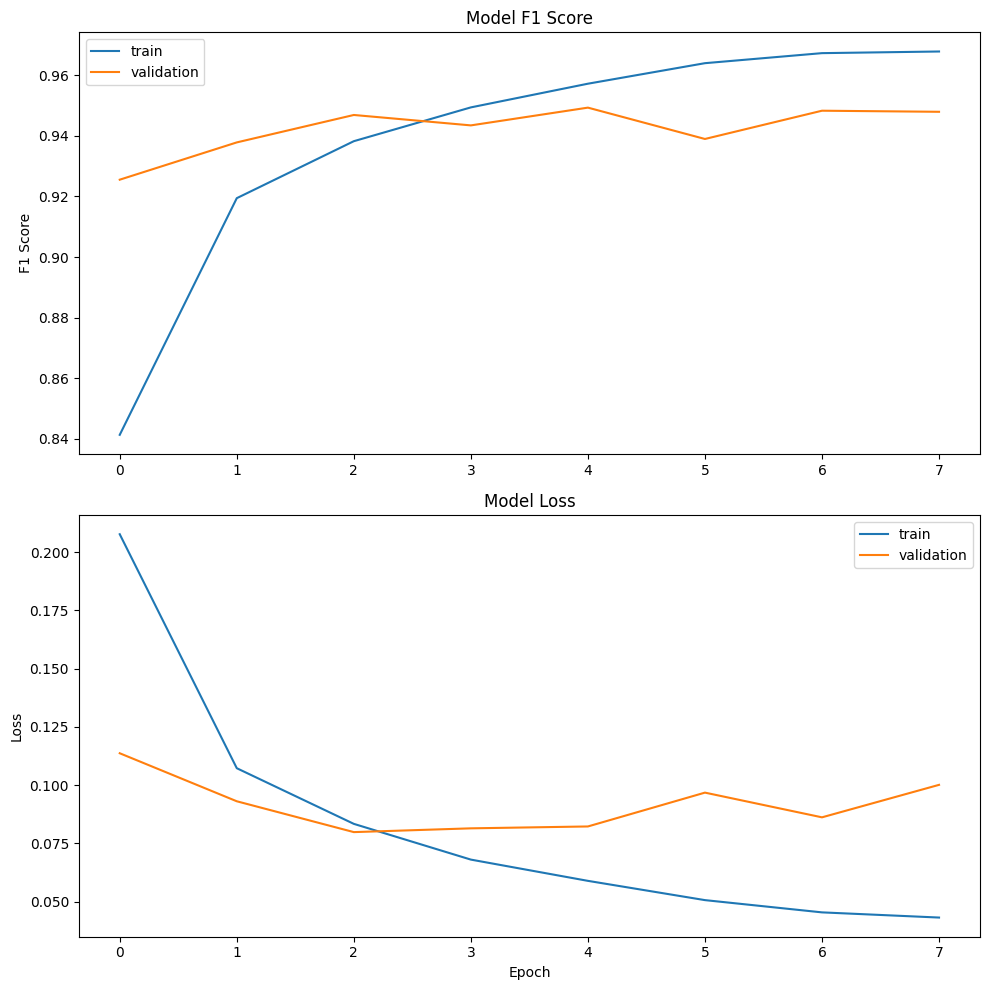

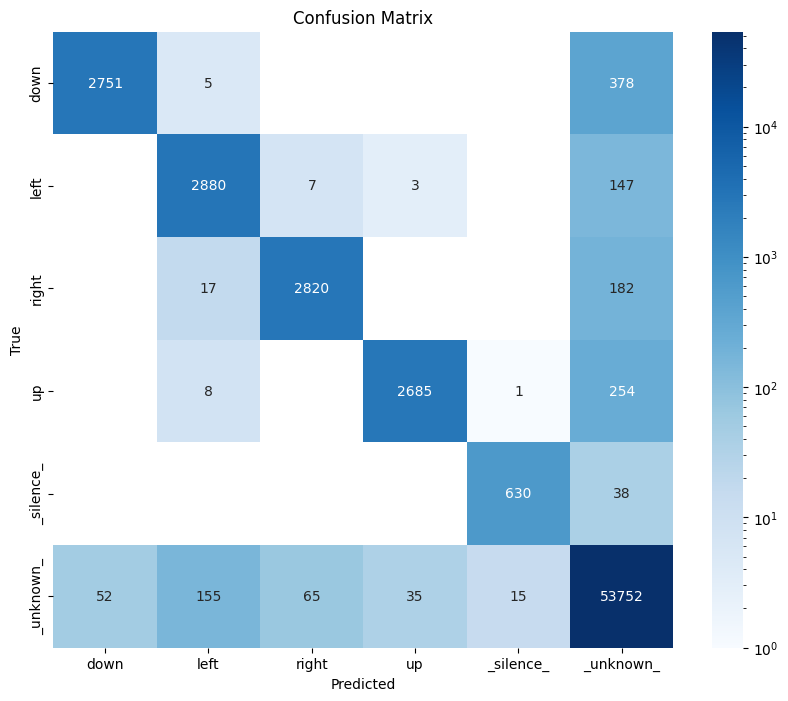

In [74]:
plot_history(history)
plot_confusion_matrix(model, preprocessed_train_ds_rnn, new_class_names)


In [76]:
evaluate_model(model, preprocessed_test_ds_rnn)

/mnt/c/Users/andre/projects/dat255/dat255-project/venv/tf-gpu-wsl/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Test accuracy: 0.9196
              precision    recall  f1-score   support

        down       1.00      0.79      0.88       406
        left       0.99      0.96      0.98       412
       right       1.00      0.88      0.94       396
          up       1.00      0.90      0.95       425
   _silence_       1.00      0.96      0.98       408
   _unknown_       0.67      1.00      0.80       408

    accuracy                           0.91      2455
   macro avg       0.94      0.91      0.92      2455
weighted avg       0.94      0.91      0.92      2455

